In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#stock network import
import torchvision.models as models

from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to the range [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root= './data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 512, shuffle = True, num_workers = 4)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 512, shuffle = False, num_workers = 4)

# Print class names
classes = trainset.classes
print("Classes in CIFAR-10 dataset:", classes)

#deifne GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Files already downloaded and verified
Files already downloaded and verified
Classes in CIFAR-10 dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [15]:
def image_to_view(image):
    image = torchvision.utils.make_grid(image)
    image = image/2+0.5
    image = image.numpy()
    image = np.transpose(image, (1,2,0))
    return image

data = iter(trainloader)
images, labels = next(data)


<Figure size 640x480 with 0 Axes>

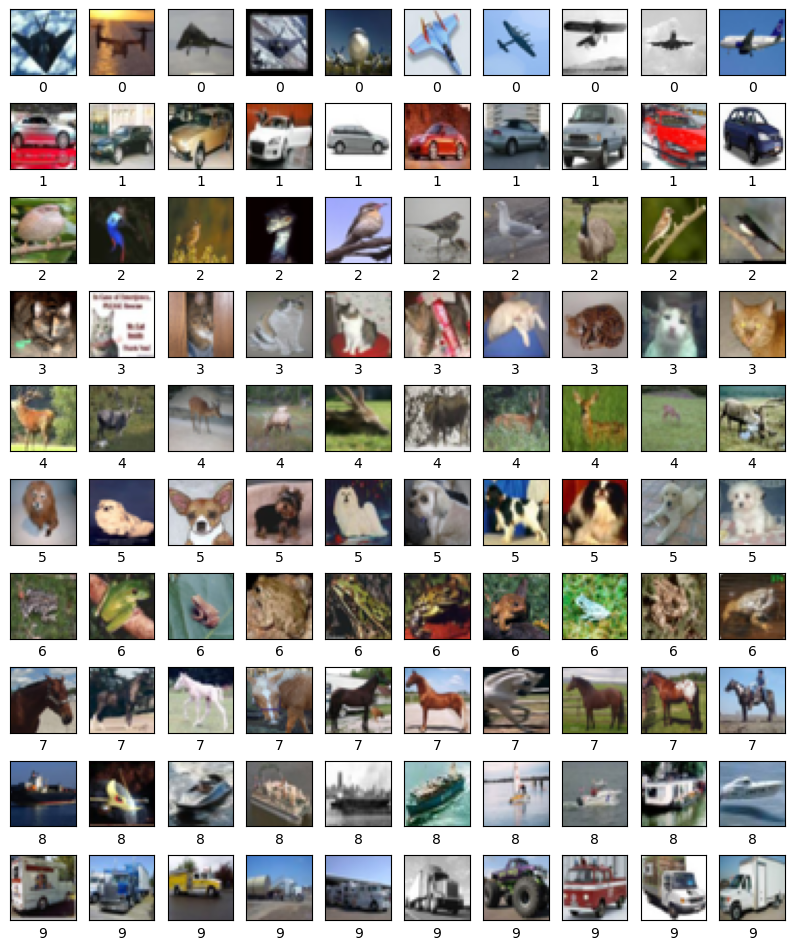

In [16]:
Cifar = plt.figure("Cifar-10 visualisation")
plt.figure(figsize=(10,12)) # mainly for me to get intuition on the data
for i in range(10): # shows 10 images per category on each row (labeled)
    counter = 0
    found_10 = 0
    while found_10 < 10:
      if labels[counter] == i:
        plt.subplot(10,10,(10*i) + found_10+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image_to_view(images[counter]))
        plt.xlabel(int(labels[counter]))
        found_10 += 1
      counter += 1
plt.show()

In [17]:
class my_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(my_CNN, self).__init__()
        
        # Convolutional Blocks
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.5)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batch_norm5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.batch_norm6 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout(0.5)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.batch_norm_fc = nn.BatchNorm1d(128)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Convolutional Blocks
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = F.relu(self.batch_norm5(self.conv5(x)))
        x = F.relu(self.batch_norm6(self.conv6(x)))
        x = self.maxpool3(x)
        x = self.dropout3(x)

        # Fully Connected Layers
        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

model = my_CNN()

PATH = '/school/intelligence_coursework/new_CNN/trained_network/new_CNN_notebook.pth'
model.load_state_dict(torch.load(PATH, map_location=device))

print(model.fc2.parameters())

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

fc_params = sum(p.numel() for p in model.fc2.parameters())
print(f"Total number of parameters: {fc_params}")




<generator object Module.parameters at 0x7fe59a333190>
Total number of parameters: 551722
Total number of parameters: 1290


In [18]:
model = model.to(device=device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9) #57%
optimizer = optim.Adam(model.parameters(), lr = 0.0015, weight_decay = 0.0001) #74%
#optimizer = optim.Adagrad(model.parameters(), lr = 0.01) #72%
print("Model device:", next(model.parameters()).device)

Model device: cuda:0


In [22]:
num_epochs = 100 #Changing number of epochs
loss_history = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        try:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 50 == 49:
                loss_history.append(running_loss/50)
                print(f'Epoch {epoch + 1}, Loss: {loss_history[epoch]:.5f}')
                running_loss = 0.0
        except Exception as e:
            print(f"Error in Epoch {epoch}, Batch {i}: {e}")
            break

Epoch 1, Loss: 1.98799
Epoch 2, Loss: 1.52810
Epoch 3, Loss: 1.33916
Epoch 4, Loss: 1.20265
Epoch 5, Loss: 1.10413
Epoch 6, Loss: 1.05350
Epoch 7, Loss: 0.99364
Epoch 8, Loss: 0.94877
Epoch 9, Loss: 0.91147
Epoch 10, Loss: 0.89381
Epoch 11, Loss: 0.86746
Epoch 12, Loss: 0.82909
Epoch 13, Loss: 0.81882
Epoch 14, Loss: 0.79138
Epoch 15, Loss: 0.76973
Epoch 16, Loss: 0.75901
Epoch 17, Loss: 0.74674
Epoch 18, Loss: 0.73029
Epoch 19, Loss: 0.71908
Epoch 20, Loss: 0.70231
Epoch 21, Loss: 0.69615
Epoch 22, Loss: 0.69167
Epoch 23, Loss: 0.68128
Epoch 24, Loss: 0.65715
Epoch 25, Loss: 0.65194
Epoch 26, Loss: 0.65056
Epoch 27, Loss: 0.64919
Epoch 28, Loss: 0.62833
Epoch 29, Loss: 0.61625
Epoch 30, Loss: 0.61594
Epoch 31, Loss: 0.60875
Epoch 32, Loss: 0.60385
Epoch 33, Loss: 0.59657
Epoch 34, Loss: 0.58789
Epoch 35, Loss: 0.59211
Epoch 36, Loss: 0.58671
Epoch 37, Loss: 0.57283
Epoch 38, Loss: 0.56752
Epoch 39, Loss: 0.56182
Epoch 40, Loss: 0.56633
Epoch 41, Loss: 0.55818
Epoch 42, Loss: 0.55673
E

In [25]:
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
model.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label.item()]] += 1
            total_pred[classes[label.item()]] += 1
            
print('Accuracy of the network on the 10 000 test images: %f %%' % (100 * correct / total))

for classname, correct_count in correct_pred.items():
    accuracy = 100* float(correct_count)/ total_pred[classname]
    print(f'Accuracy for: {classname:5s} is {accuracy:0.1f} %')


Accuracy of the network on the 10 000 test images: 84.030000 %
Accuracy for: airplane is 81.7 %
Accuracy for: automobile is 92.1 %
Accuracy for: bird  is 72.6 %
Accuracy for: cat   is 66.6 %
Accuracy for: deer  is 87.9 %
Accuracy for: dog   is 75.4 %
Accuracy for: frog  is 92.2 %
Accuracy for: horse is 86.2 %
Accuracy for: ship  is 92.7 %
Accuracy for: truck is 92.9 %


In [27]:
PATH = '/school/intelligence_coursework/new_CNN/trained_network/new_CNN_notebook.pth'
torch.save(model.state_dict(), PATH)

Precision: 0.8402
Recall: 0.8403
F1 Score: 0.8388


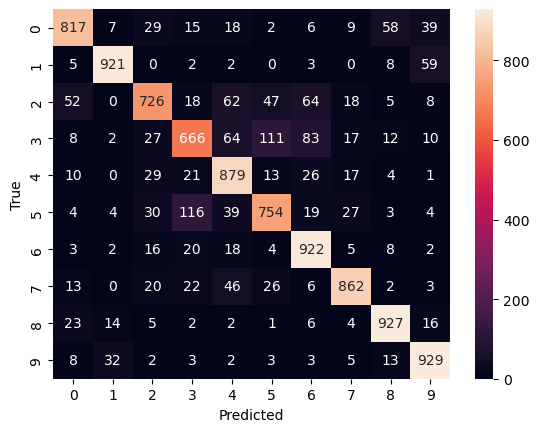

In [26]:
import numpy as np

all_labels = []
all_predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

# Concatenate all batches
all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

# Calculate metrics
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

# Print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
